# Demodulación de FM

El osciloscopio es un instrumento de cabecera en la electrónica, pero dentro de comunicaciones, no es tan importante como el analizador de espectro. No obstante tambien el analizador de espectro no tiene las herramientas para demodular FM, para lo cual unicamente contamos con las funciones de Bessel.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as dsp
#from .\ploteos.ipynb import plot_spec

Nos armamos una linda función para plotear espectros cada vez que lo necesitemos.

In [55]:
def plot_spec(signal,fs,tipo="full",win="rect"):
    espec=20*np.log10(np.abs(np.fft.fft(signal))/len(signal))
    espec=np.fft.fftshift(espec)
    fcia=np.linspace(-fs/2,fs/2,len(signal))
    if tipo=="half":
        espec=espec[len(signal)//2:]
        fcia=fcia[len(signal)//2:]
    plt.figure()
    plt.title('Espectro de la señal')
    plt.ylim(np.max(espec)-75,np.max(espec)+5)
    plt.plot(fcia,espec)

Vamos a definir los parametros minimos de una señal modulada en FM

In [56]:
##### constantes ######
deltaf=75000   # desviación
fmsj=5e3      # frecuencia de mensaje
m=deltaf/fmsj # indice de modulacion de fm, el parametro que usamos para entrar a Bessel
fc=100e3      # frecuencia de portadora


Los parametros del osciloscopio

In [57]:
############################
### Parametros del DSO  ####
############################

N=2500
fbt=100e-6
div=10
fs=N/(fbt*div)
t=np.linspace(0,N/fs,N)
print("ts = {} s".format(t[1]))
print("f_Nys= {} Hz ".format(fs/2))

ts = 4.001600640256103e-07 s
f_Nys= 1250000.0 Hz 


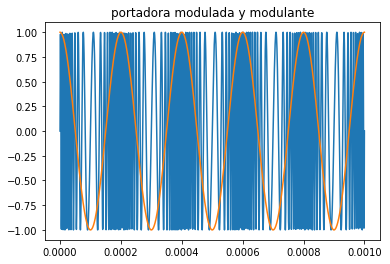

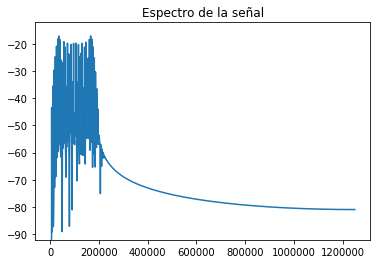

In [58]:
msj=np.cos(2*np.pi*fmsj*t)  # mensaje
modulante=np.sin(2*np.pi*fmsj*t) ### en fm la modulante queda integrada 

fm=np.sin(2*np.pi*fc*t+m*modulante)
plt.figure()
plt.title("portadora modulada y modulante")
plt.plot(t,fm,t,msj)
plot_spec(fm,fs,tipo="half")

## Envolvente compleja

### Diagrama en bloques de un receptor SDR

<img src=".\SDR.bmp">

### Demodulador de cuadratura

<img src=".\IQ.bmp">

### Implementamos el filtro pasabajos

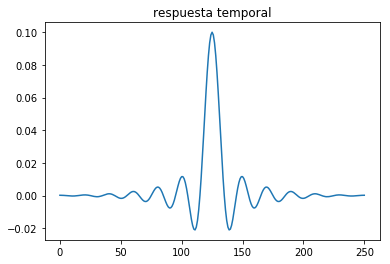

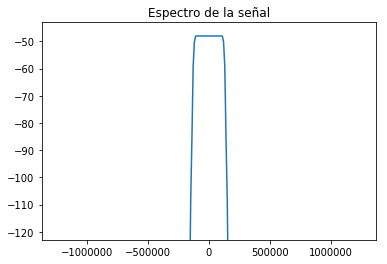

In [59]:
filtro=dsp.firwin(251,250e3/fs)
plt.title("respuesta temporal")
plt.plot(filtro) 
plot_spec(filtro,fs)

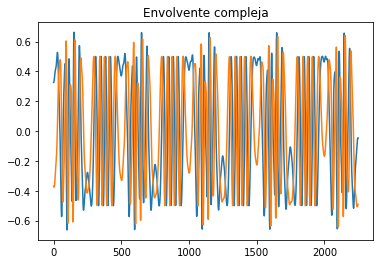

In [60]:
error=100

ComplexEnvelope=fm*np.power(np.e,1j*2*np.pi*(fc+error)*t)
ComplexEnvelope_filt=np.convolve(filtro,ComplexEnvelope,mode="valid")
#plot_spec(ComplexEnvelope,fs)
#plot_spec(ComplexEnvelope_filt,fs)
plt.title("Envolvente compleja")
plt.plot(np.real(ComplexEnvelope_filt))
plt.plot(np.imag(ComplexEnvelope_filt))


Hasta aca llegamos a obtener la banda base compleja de la señal de FM que generamos. De aqui en adelante implementaremos la version digital de un demodulador de cuadratura

### Demodulador de cuadratura

<img src=".\cuad_demod.bmp">

## y[t]=arg(x[t]*conj(x[t-1]))

In [61]:
### demodulacion en cuadratura ####

def FM_demod (señal,fs):
    return np.angle(señal[:-1]*np.conjugate(señal[1:]))*fs/(2*np.pi)

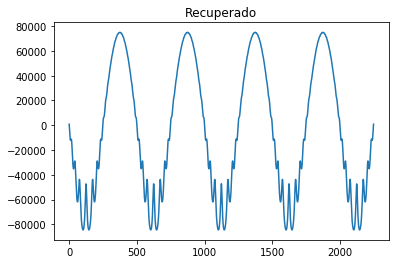

In [62]:
demod= FM_demod(ComplexEnvelope_filt,fs)
plt.figure()
plt.title("Recuperado")
plt.plot(demod)

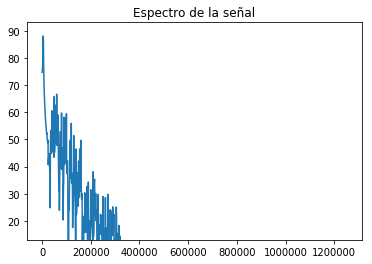

In [63]:
plot_spec(demod,fs,tipo="half")

# Analizador de modulación
Que podemos sacar del grafico recuperado


<img src=".\fam.bmp">

Igual que sucede con un multimetro cuando mide señales no senoidales, aparece el mismo problema cuando se quiere medir la desviación de frecuencia como la salida de un discriminador de FM. Podemos detectar el pico, que correspondera a la desviacion pico o podemos detectar la desviación de frecuencia eficaz, si estamos modulando señales complejas. De todas formas toda la informacion esta disponible en la señal demodulada!!

### - Desviacion Pico+ - Pico-
### - Desviación RMS


In [64]:
print("Desviación Pico+ {} Hz / Desviación Pico- {} Hz".format(np.max(demod),np.min(demod)))
print("Desviación RMS {} Hz".format(np.sqrt(np.mean(demod**2))))


Desviación Pico+ 75092.44064400067 Hz / Desviación Pico- -84523.59126821975 Hz
Desviación RMS 53493.07795727424 Hz


### - Frecuencia de la portadora
El offset de frecuencia respecto de la portadora corresponde al valor medio de la señal demodulada. Es decir, valor medio cero indica que esta centrada. NOTA: especial cuidado a que si la cantidad de ciclos no es entera vamos a tener un error!! para eso ventaneamos


Error de frecuencia p+p- -4715.57531210954 Hz
Error de frecuencia -5413.86060555133 Hz
Error de frecuencia con ventana -352.15472463846413 Hz


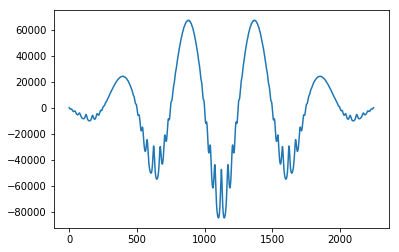

In [65]:
win=dsp.windows.hamming(len(demod))
print("Error de frecuencia p+p- {} Hz".format((np.max(demod)+np.min(demod))/2))
print("Error de frecuencia {} Hz".format(np.mean(demod)))
print("Error de frecuencia con ventana {} Hz".format(np.mean(demod*win)))
plt.plot(demod*win)

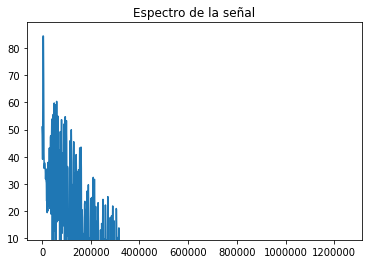

In [66]:
plot_spec(demod*win,fs,tipo="half")